# **Maintenance du clustering : maintenance non supervisée**

Il s'agit ici de proposer des périodes de maintenance, donc des périodes au dessus desquelles le modèle est à la dérive c'est-à-dire ne parvient plus à prédire des segments pertinents et stables des observations avec le moins de bruits psossible.

Il s'agira alors de :
- **Déterminer à quel moment la performance tombe sous un seuil critique**
- **En déduire la durée de validité du modèle → donc la fréquence de maintenance**



## **Chargement des données** 


⚠️ Pour des besoins de plus de ressources, une partie du projet a été implémentée sur colab avec des machines pourvues de **GPU L4**.

In [ ]:
# A exécuter uniquement avec colab
# Dans Colab Pay As You Go WorkSpace (nécessaire pour implémenter
# objectif: besoin de plus de ressources avec des GPU type L4)

# clone le repo :
! git clone https://github.com/donat-konan33/olist-ecommerce-client-clustering.git

# installation des dépendances
! curl -sSL https://install.python-poetry.org | python3 -
! export PATH="$HOME/.local/bin:$PATH"

import os
os.environ["PATH"] += ":/root/.local/bin"

! poetry --version

%cd olist-ecommerce-client-clustering/
! poetry install

# direction dans le repository dossier notebooks
%cd notebooks

In [1]:
import os
import pandas as pd
from scipy.stats import wasserstein_distance, ks_2samp
from scipy.spatial.distance import directed_hausdorff
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns
import sys
from pathlib import Path
from alibi_detect.cd import TabularDrift, MMDDrift


None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
project_root = Path().resolve().parents[0]
print(project_root)
sys.path.append(str(project_root /"src"))
from olist_ecommerce_client_clustering.utils import RFMSClusteringModel

/home/nokan/code/donat-konan33/olist-ecommerce-client-clustering


In [18]:
help(RFMSClusteringModel)

Help on class RFMSClusteringModel in module olist_ecommerce_client_clustering.utils:

class RFMSClusteringModel(builtins.object)
 |  RFMSClusteringModel(umap_n_neighbors=50, umap_random_state=12, dbscan_eps=0.6)
 |
 |  Entire Clustering model class
 |
 |  Methods defined here:
 |
 |  __init__(self, umap_n_neighbors=50, umap_random_state=12, dbscan_eps=0.6)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  dbcv(self)
 |      Get density validity of dbscan clustering model
 |      Output : a tuple of :
 |                  nb_cluster : Number of clusters
 |                  noise_ratio : Number of noises
 |                  clustered_ratio : ratio of objects classfied not as a noise
 |
 |  fit(self, X_ref)
 |      Docstring for model_pipeline
 |      X: Data to input which labels must be predicted ;
 |      whatever features it contains, "frequency", "monetary", "recency"
 |      and "review_score" are mandatory
 |
 |  get_baseline_labels(self)
 |
 |  get_umap_

In [5]:
here = Path().resolve()
repo_wd = here.parent

rfms_path = repo_wd / "data/processed/rfms_active_reviewers.parquet"
rfms = pd.read_parquet(rfms_path)[["customer_unique_id", "recency", "frequency",
                                   "monetary", "review_score",
                                   "order_purchase_timestamp"]] # uniquement pour le client qui notent après commandes:
rfms

,customer_unique_id,recency,frequency,monetary,review_score,order_purchase_timestamp
0,831a032a3327e2b8325faf9d37953870,159,1,314.34,5.0,2018-05-11 16:35:19
1,d4b1297d645ec19df4cd0af8cd6fe14a,214,1,59.18,2.0,2018-03-17 15:32:31
2,dc184f142552a38189d5d5428d1984a6,236,1,222.68,1.0,2018-02-22 20:53:14
3,1acfddcc366d45e07b84eedc46282cdc,66,1,264.22,5.0,2018-08-11 20:58:44
4,79e12483f9b14c3254db94bd137a4b70,71,1,1480.73,1.0,2018-08-06 18:45:01
...,...,...,...,...,...,...
95375,84b7440c2a25a2d908e7226cbeb300e8,339,1,190.03,5.0,2017-11-12 12:47:01
95376,fc06116082a6e23a21072673c4eb12f3,591,1,38.68,5.0,2017-03-05 17:27:31
95377,b3be47a665b75181ac9728442d970dde,528,1,134.56,5.0,2017-05-07 12:47:57
95378,d468040bda183009e4ec5a3efb6350ae,348,1,63.37,5.0,2017-11-03 09:41:04


In [6]:
# données clients de la période avant "2018-01-01" ayant servi au choix du pipeline du modèle
df1 = rfms[rfms['order_purchase_timestamp'] < "2018-01-01"]
T_0 = df1[["customer_unique_id", 'recency', 'frequency', 'monetary', 'review_score']]

# données clients de la période après "2018-01-01"
T_n = rfms.copy()
T_n["month"] = T_n.order_purchase_timestamp.dt.to_period("M")
T_n

,customer_unique_id,recency,frequency,monetary,review_score,order_purchase_timestamp,month
0,831a032a3327e2b8325faf9d37953870,159,1,314.34,5.0,2018-05-11 16:35:19,2018-05
1,d4b1297d645ec19df4cd0af8cd6fe14a,214,1,59.18,2.0,2018-03-17 15:32:31,2018-03
2,dc184f142552a38189d5d5428d1984a6,236,1,222.68,1.0,2018-02-22 20:53:14,2018-02
3,1acfddcc366d45e07b84eedc46282cdc,66,1,264.22,5.0,2018-08-11 20:58:44,2018-08
4,79e12483f9b14c3254db94bd137a4b70,71,1,1480.73,1.0,2018-08-06 18:45:01,2018-08
...,...,...,...,...,...,...,...
95375,84b7440c2a25a2d908e7226cbeb300e8,339,1,190.03,5.0,2017-11-12 12:47:01,2017-11
95376,fc06116082a6e23a21072673c4eb12f3,591,1,38.68,5.0,2017-03-05 17:27:31,2017-03
95377,b3be47a665b75181ac9728442d970dde,528,1,134.56,5.0,2017-05-07 12:47:57,2017-05
95378,d468040bda183009e4ec5a3efb6350ae,348,1,63.37,5.0,2017-11-03 09:41:04,2017-11


In [32]:
print("La plus ancienne date d'achat : ", T_n[T_n["month"] >= '2018-01'].order_purchase_timestamp.min())
print("La plus récente date d'achat : ", T_n[T_n["month"] >= '2018-01'].order_purchase_timestamp.max())

La plus ancienne date d'achat :  2018-01-01 02:48:41
La plus récente date d'achat :  2018-10-17 17:30:18


On constate des **données clients sur 10 mois dans cette période de 2018 depuis le 1er Janvier**. La recherche du drift ne serait donc pas pertinent sur des semaines, encore mois sur des trimestres car ces choix seraient respectivement trop bruités et trop grossiers: **une période de suivi mensuel de la performance du clustering serait plus appropriée**.

In [33]:
T_n[T_n["month"] >= '2018-01'].order_purchase_timestamp.dt.to_period("M").value_counts()

order_purchase_timestamp
2018-01    6964
2018-03    6960
2018-04    6733
2018-05    6709
2018-08    6424
2018-02    6400
2018-07    6138
2018-06    6056
2018-09      12
2018-10       4
Freq: M, Name: count, dtype: int64

In [7]:
def get_ti_data(T_n: pd.DataFrame, t_k: str, is_cumulative: bool=True):
    """
    T_n: Dataframe k with month variable corresponding to all periods t_k
    t_k: month data needed like '2018-03'
    """
    if is_cumulative:
        return T_n[T_n.month <= t_k]
    return T_n[T_n.month == t_k]


# **Métriques de détection de Drifts**

## **Data Drifts**

Les clients ont ils changé de comportement ?

### - **A / Kolmogorov-Smirnov Drift détector**

Il s'agit d'un test statistique  non paramétrique utilisé pour évaluer si un échantillon suit une distribution de probabilité spécifique ou pour comparer deux échantillons afin de déterminer s'ils proviennent de la même distribution.
 Il repose sur la distance maximale entre la fonction de distribution cumulative empirique (FDC) de l'échantillon et la fonction de distribution cumulative théorique, ou entre les fonctions de distribution cumulatives empiriques de deux échantillons.

L'interprétation des résultats du test se fait principalement à l'aide de la statistique de test, notée D, qui représente la plus grande différence absolue entre les fonctions de distribution.
 Cette statistique est ensuite comparée à des valeurs critiques ou à une valeur p pour prendre une décision.
 Une faible valeur p (généralement inférieure à 0,05) indique qu'il existe une différence significative entre les distributions, conduisant au rejet de l'hypothèse nulle.
 À l'inverse, une valeur p élevée suggère qu'il n'y a pas suffisamment de preuves pour rejeter l'hypothèse nulle, ce qui signifie que les distributions sont similaires.

Le test peut être utilisé sous deux formes principales : le test à un échantillon, qui compare un échantillon à une distribution théorique, et le test à deux échantillons, qui compare deux échantillons indépendants.
 Il est particulièrement utile lorsque la distribution sous-jacente est inconnue ou inconnue, car il ne repose pas sur des hypothèses strictes sur les paramètres de la distribution.
 Toutefois, il présente certaines limites, notamment une sensibilité accrue à la taille de l'échantillon, où de grands échantillons peuvent détecter des différences triviales, tandis que de petits échantillons peuvent manquer de puissance pour détecter des différences réelles.
 De plus, le test suppose que les données sont continues et indépendantes, et que les paramètres de la distribution théorique sont connus ou estimés à partir des données.

[source](https://fr.statisticseasily.com/glossaire/qu'est-ce-que-le-test-d'ajustement-de-Kolmogorov-Smirnov/)

In [8]:
# échantillonnage
def sample_for_ks(X, n=10000, random_state=42):
    if len(X) > n:
        return X.sample(n, random_state=random_state)
    return X

def ks_results(reference: pd.DataFrame):
    """
    Reference : rfms data with purchase month set
    """

    def ks_drift(reference, current):
        """
        Kolmogorov-Smirnov test for data drift
        """
        stat, p_value = ks_2samp(
            reference,
            current,
            alternative="two-sided",
            mode="asymp"
        )
        return stat, p_value

    ks_results = []

    for month in sorted(reference["month"].unique()):
        current = reference[reference["month"] <= month]

        ks_r, p_r = ks_drift(reference["recency"], current["recency"])
        ks_f, p_f = ks_drift(reference["frequency"], current["frequency"])
        ks_m, p_m = ks_drift(reference["monetary"], current["monetary"])
        ks_s, p_s = ks_drift(reference["review_score"], current["review_score"])

        ks_results.append({
            "month": str(month),
            "ks_recency": ks_r,
            "ks_frequency": ks_f,
            "ks_monetary": ks_m,
            "ks_review": ks_s,
        })

    return pd.DataFrame(data=ks_results)


### **Le test statistique de KS peut être obtenu directement avec avec le module alibi-detect**


In [9]:
## Tests Ks pour chaque variation mensuelle des données

def reference_pipeline(T_0):
    pipeline = RFMSClusteringModel()
    pipeline.fit(T_0)
    return pipeline

def data_drift(T_0, T_k, pipeline):
    """
    T_0 : reference data
    T_k : data to monitor
    """
    X_ref = T_0
    X_prod = T_k
    columns = list(T_0.iloc[:, 1:].columns)
    month = str(X_prod.month.mode().values[0])

    ## Standardize the data
    X_ref_scaled = pipeline.pipeline.named_steps["preprocessor"].transform(X_ref)
    X_prod_scaled = pipeline.pipeline.named_steps["preprocessor"].transform(X_prod)

    ## Initialize drift detector
    cd = TabularDrift(
        X_ref_scaled,
        p_val=0.05,       # Seuil FDR = pvalue ajustée pour réduction des fp
        correction='fdr'  # Benjamini-Hochberg
    )
    ## Predict drift
    preds = cd.predict(X_prod_scaled)
    print(f"Drift preds for {month} : ", preds)

    # Print results
    print("Drift Detected:", preds['data']['is_drift'])
    print("Feature-wise P-values:")
    for name, p_val in zip(X_ref.columns, preds['data']['p_val']):
        print(f"{name}: {p_val:.4f}")

    ## Plot distributions (2x2 layout)
    def plot_drift(X_ref, X_prod, features):
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        axes = axes.flatten()

        for i, feat in enumerate(features):
            sns.kdeplot(X_ref[feat], label='Reference', fill=True, ax=axes[i])
            sns.kdeplot(X_prod[feat], label=f'Production - {month}', fill=True, ax=axes[i])
            axes[i].set_title(f"Feature Drift: {feat}")
            axes[i].set_xlabel(feat)
            axes[i].set_ylabel('Density')
            axes[i].legend()

        plt.tight_layout()
        plt.show()

    plot_drift(X_ref[columns], X_prod[columns], columns)


In [10]:
def plot_all_data_drift(T_n, t_k_min: str='2018-01'):
    months = [str(month) for month in sorted(T_n[T_n["month"] >= t_k_min].month.unique())]
    pipeline = reference_pipeline(T_0)

    for month in months:
        T_k  = get_ti_data(T_n=T_n, t_k=month, is_cumulative=False)
        data_drift(T_0, T_k, pipeline)


### **Data Monitoring jusqu'à de '2018-01' à '2018-10'**

Drift preds for 2018-01 :  {'data': {'is_drift': 1, 'distance': array([0.00402407, 0.0149141 , 0.9995812 , 0.01577007], dtype=float32), 'p_val': array([0.99997145, 0.13762738, 0.        , 0.1004185 ], dtype=float32), 'threshold': 0.0125}, 'meta': {'name': 'TabularDrift', 'online': False, 'data_type': None, 'version': '0.13.0', 'detector_type': 'drift'}}
Drift Detected: 1
Feature-wise P-values:
customer_unique_id: 1.0000
recency: 0.1376
frequency: 0.0000
monetary: 0.1004


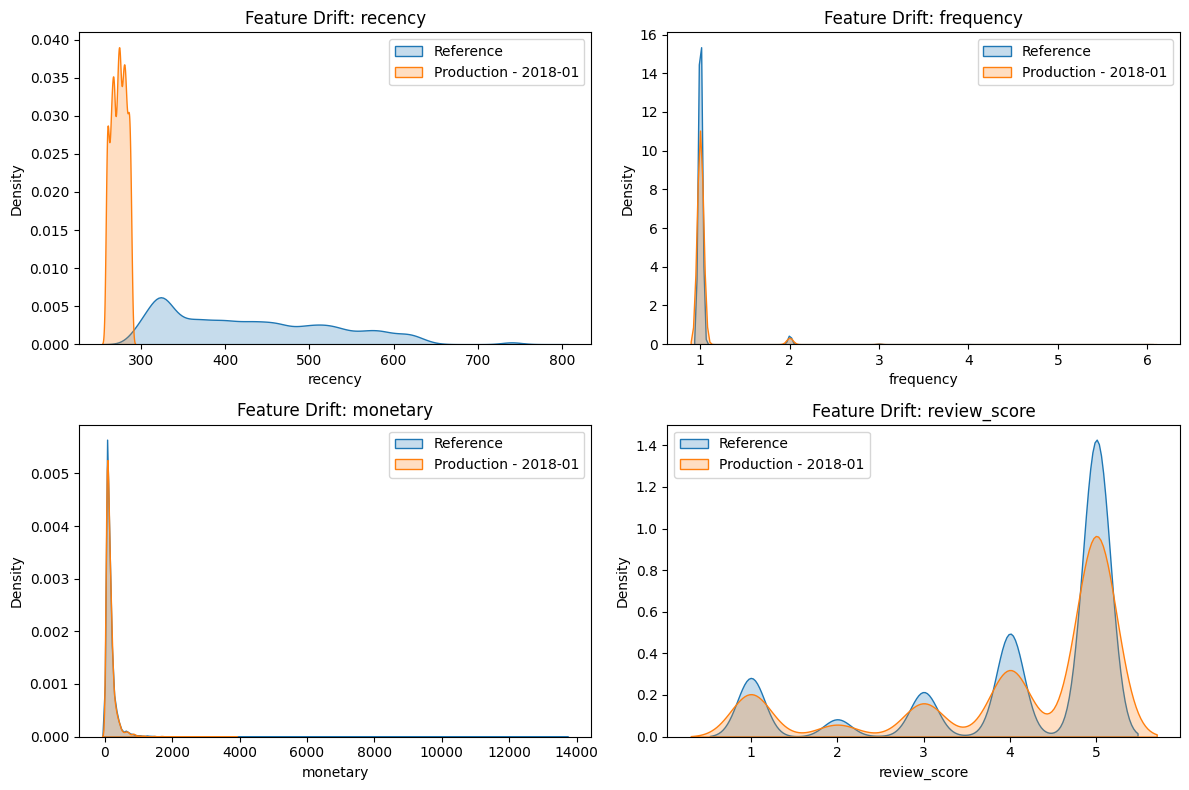

Drift preds for 2018-02 :  {'data': {'is_drift': 1, 'distance': array([0.01025819, 0.02869772, 1.        , 0.0706815 ], dtype=float32), 'p_val': array([5.9716332e-01, 2.0277759e-04, 0.0000000e+00, 1.2022967e-24],
      dtype=float32), 'threshold': 0.037500000000000006}, 'meta': {'name': 'TabularDrift', 'online': False, 'data_type': None, 'version': '0.13.0', 'detector_type': 'drift'}}
Drift Detected: 1
Feature-wise P-values:
customer_unique_id: 0.5972
recency: 0.0002
frequency: 0.0000
monetary: 0.0000


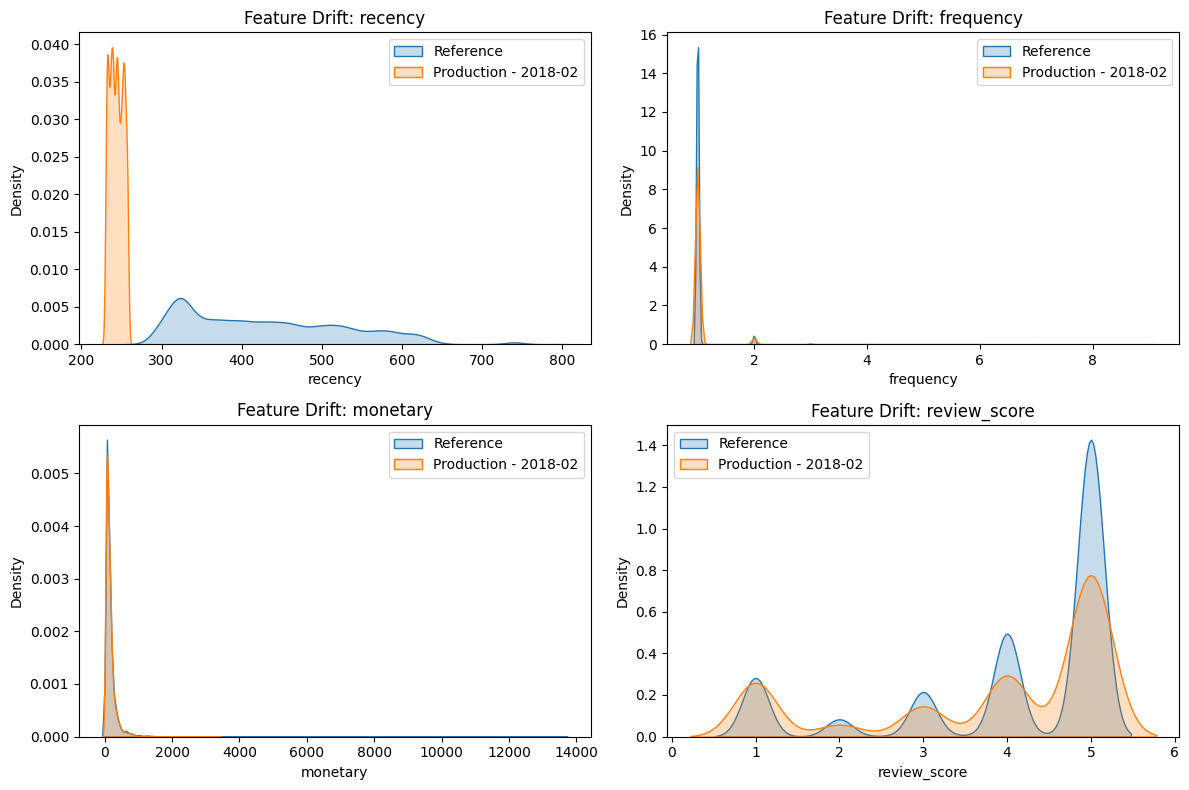

Drift preds for 2018-03 :  {'data': {'is_drift': 1, 'distance': array([0.00432967, 0.03349265, 1.        , 0.08990743], dtype=float32), 'p_val': array([9.9985564e-01, 2.8428510e-06, 0.0000000e+00, 1.3942920e-42],
      dtype=float32), 'threshold': 0.037500000000000006}, 'meta': {'name': 'TabularDrift', 'online': False, 'data_type': None, 'version': '0.13.0', 'detector_type': 'drift'}}
Drift Detected: 1
Feature-wise P-values:
customer_unique_id: 0.9999
recency: 0.0000
frequency: 0.0000
monetary: 0.0000


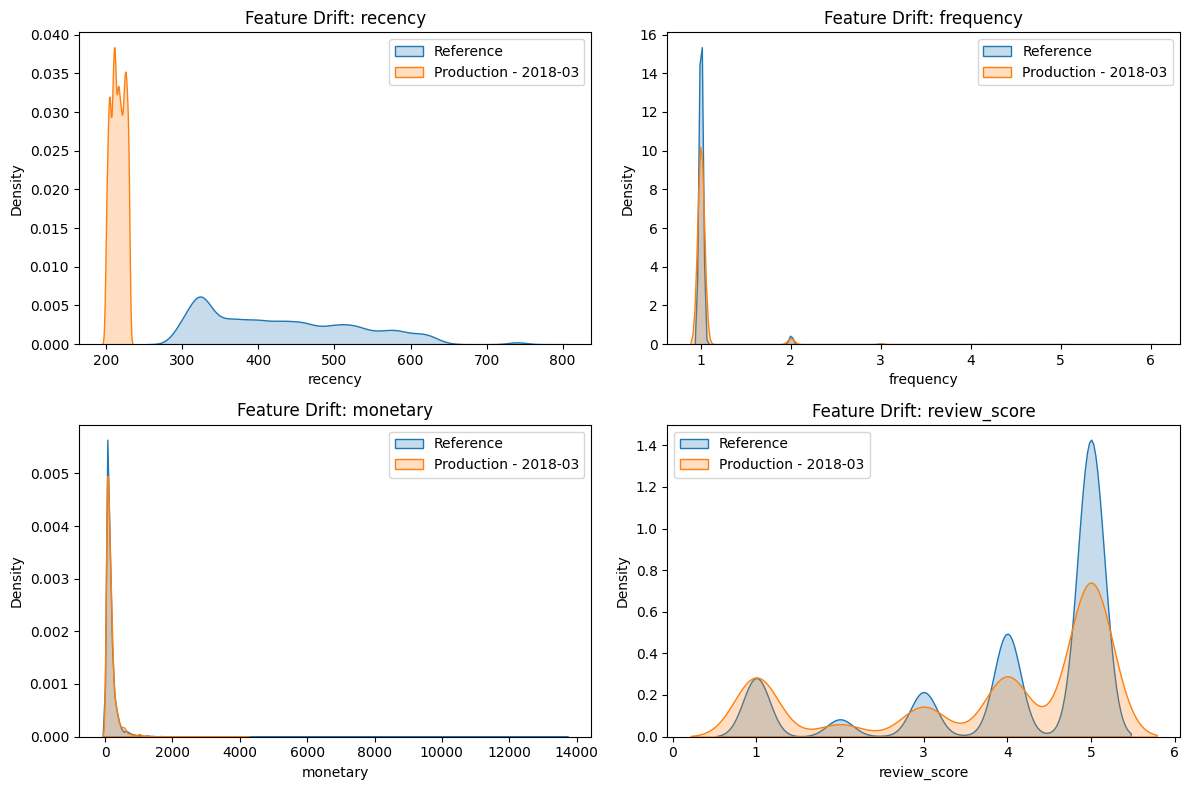

Drift preds for 2018-04 :  {'data': {'is_drift': 1, 'distance': array([0.00288501, 0.03282558, 1.        , 0.02559579], dtype=float32), 'p_val': array([1.0000000e+00, 6.9571320e-06, 0.0000000e+00, 9.5678313e-04],
      dtype=float32), 'threshold': 0.037500000000000006}, 'meta': {'name': 'TabularDrift', 'online': False, 'data_type': None, 'version': '0.13.0', 'detector_type': 'drift'}}
Drift Detected: 1
Feature-wise P-values:
customer_unique_id: 1.0000
recency: 0.0000
frequency: 0.0000
monetary: 0.0010


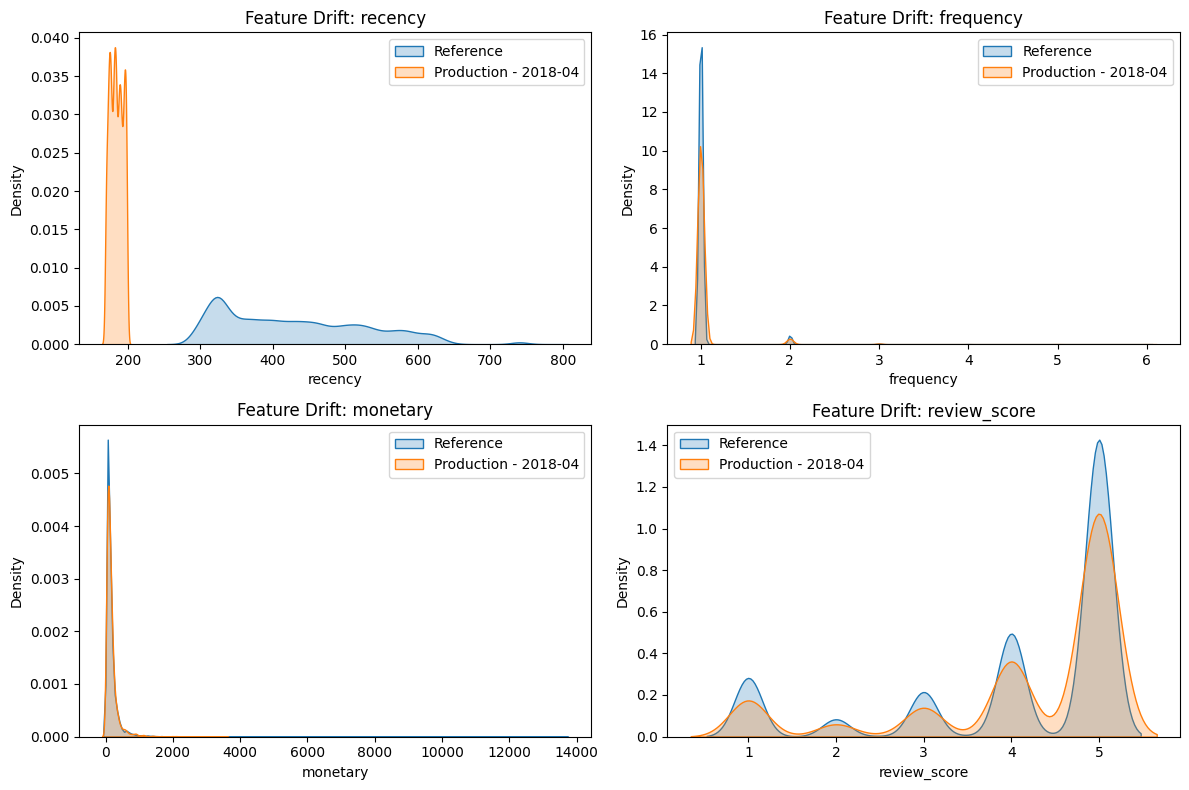

Drift preds for 2018-05 :  {'data': {'is_drift': 1, 'distance': array([0.00746607, 0.03923152, 1.        , 0.03505488], dtype=float32), 'p_val': array([9.0029758e-01, 3.3847854e-08, 0.0000000e+00, 1.2460260e-06],
      dtype=float32), 'threshold': 0.037500000000000006}, 'meta': {'name': 'TabularDrift', 'online': False, 'data_type': None, 'version': '0.13.0', 'detector_type': 'drift'}}
Drift Detected: 1
Feature-wise P-values:
customer_unique_id: 0.9003
recency: 0.0000
frequency: 0.0000
monetary: 0.0000


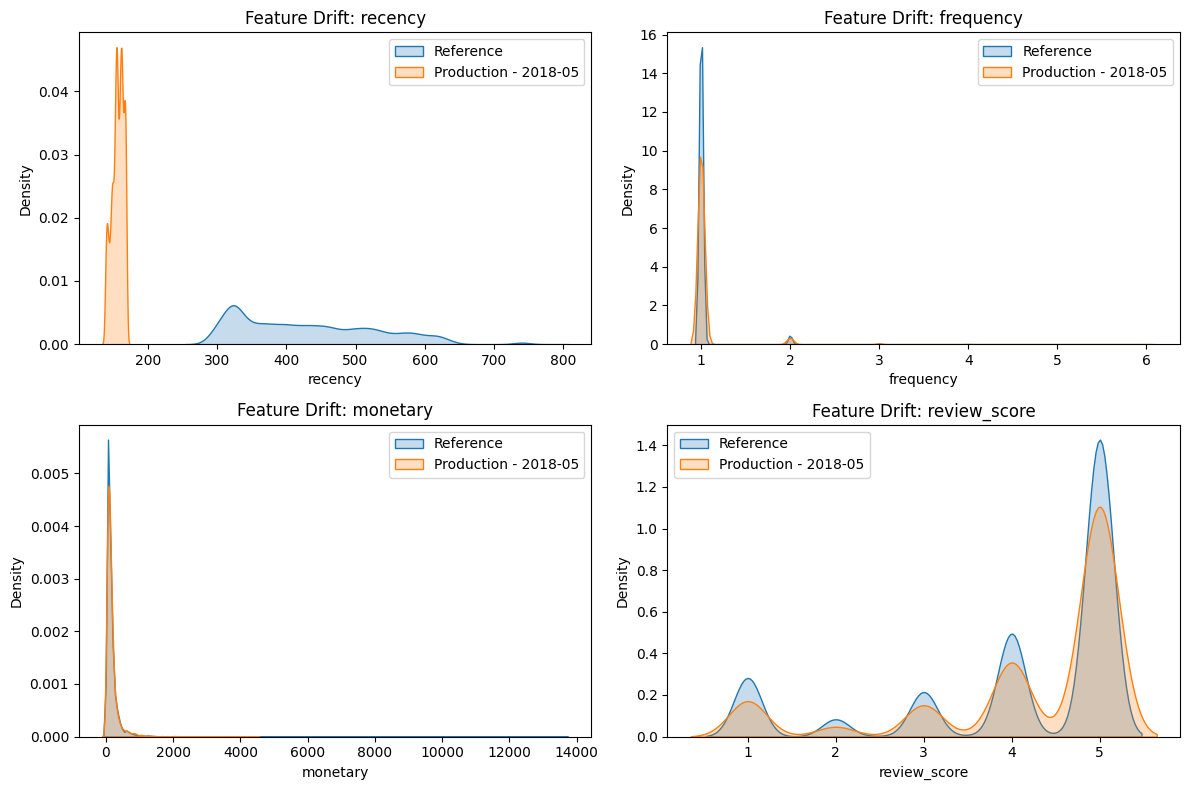

Drift preds for 2018-06 :  {'data': {'is_drift': 1, 'distance': array([0.00762629, 0.04568599, 1.        , 0.06579591], dtype=float32), 'p_val': array([9.1467696e-01, 4.5783663e-10, 0.0000000e+00, 2.0153554e-20],
      dtype=float32), 'threshold': 0.037500000000000006}, 'meta': {'name': 'TabularDrift', 'online': False, 'data_type': None, 'version': '0.13.0', 'detector_type': 'drift'}}
Drift Detected: 1
Feature-wise P-values:
customer_unique_id: 0.9147
recency: 0.0000
frequency: 0.0000
monetary: 0.0000


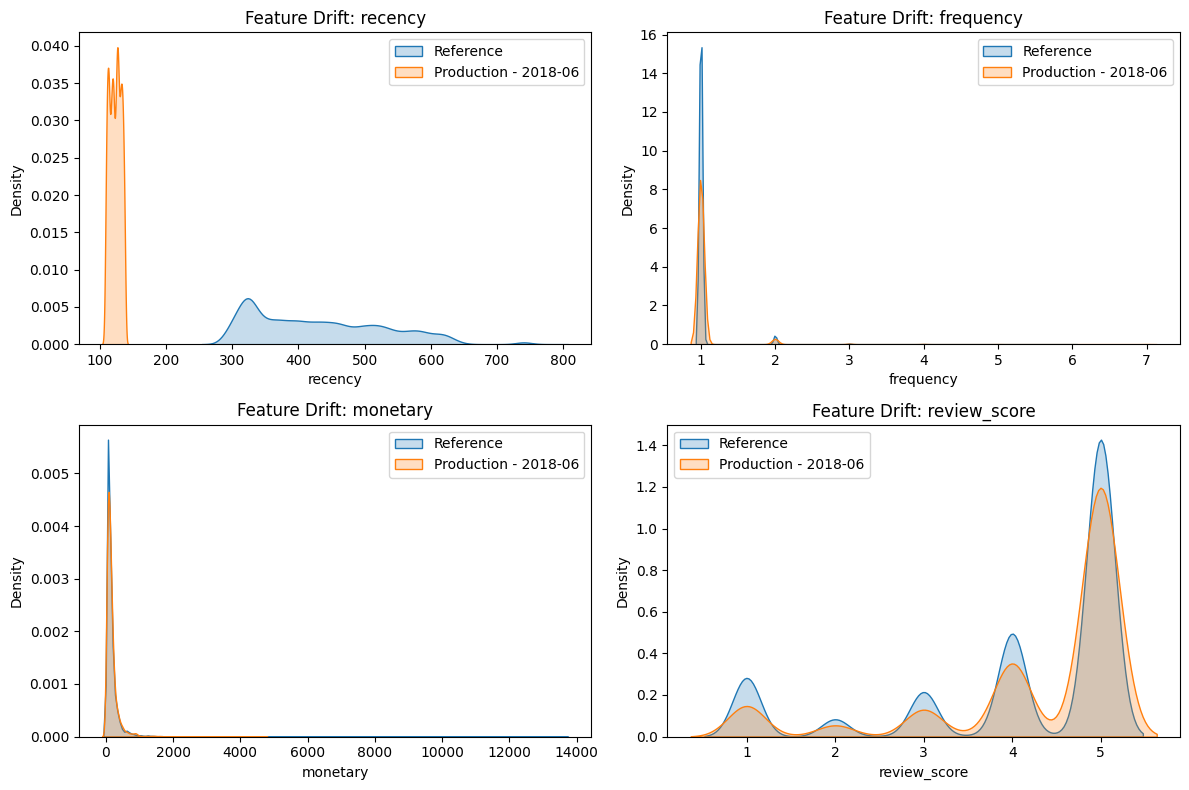

Drift preds for 2018-07 :  {'data': {'is_drift': 1, 'distance': array([0.00682837, 0.03608098, 1.        , 0.07196334], dtype=float32), 'p_val': array([9.6220416e-01, 1.6434385e-06, 0.0000000e+00, 1.2403714e-24],
      dtype=float32), 'threshold': 0.037500000000000006}, 'meta': {'name': 'TabularDrift', 'online': False, 'data_type': None, 'version': '0.13.0', 'detector_type': 'drift'}}
Drift Detected: 1
Feature-wise P-values:
customer_unique_id: 0.9622
recency: 0.0000
frequency: 0.0000
monetary: 0.0000


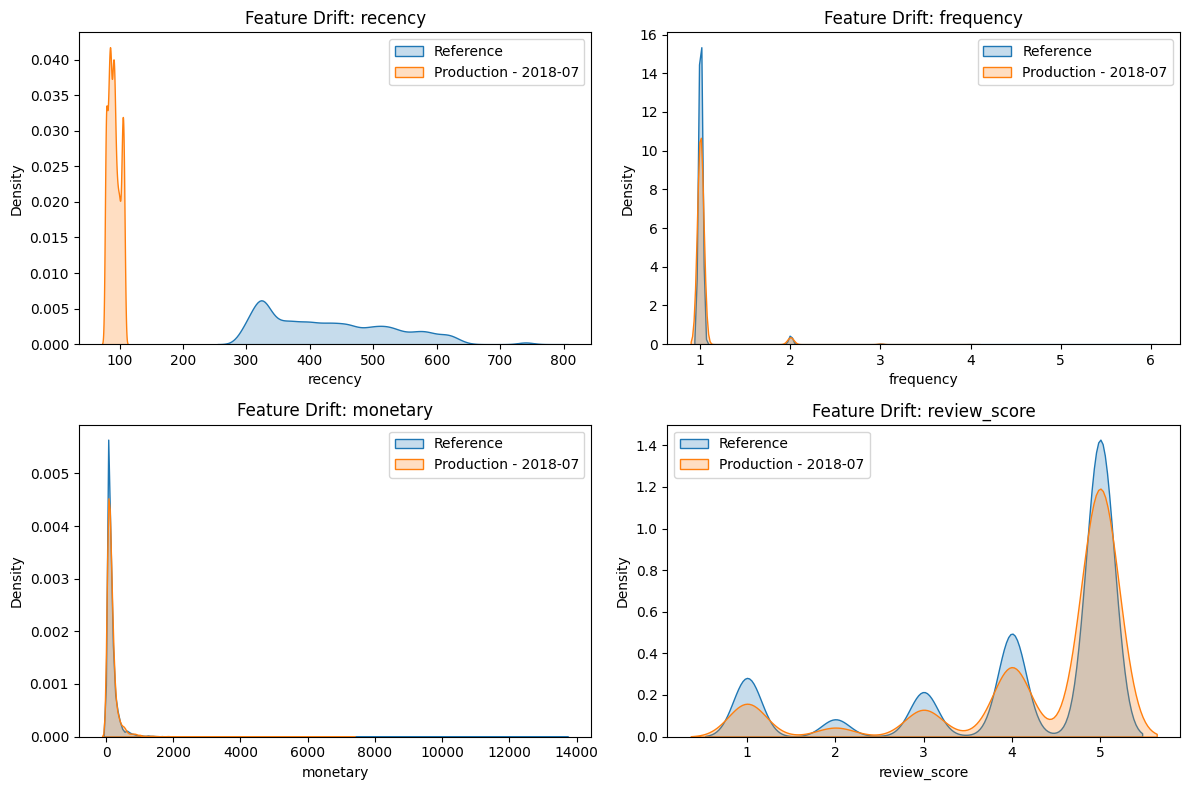

Drift preds for 2018-08 :  {'data': {'is_drift': 1, 'distance': array([0.00824834, 0.01653187, 1.        , 0.05956762], dtype=float32), 'p_val': array([8.3837736e-01, 9.3198985e-02, 0.0000000e+00, 1.1103541e-17],
      dtype=float32), 'threshold': 0.025}, 'meta': {'name': 'TabularDrift', 'online': False, 'data_type': None, 'version': '0.13.0', 'detector_type': 'drift'}}
Drift Detected: 1
Feature-wise P-values:
customer_unique_id: 0.8384
recency: 0.0932
frequency: 0.0000
monetary: 0.0000


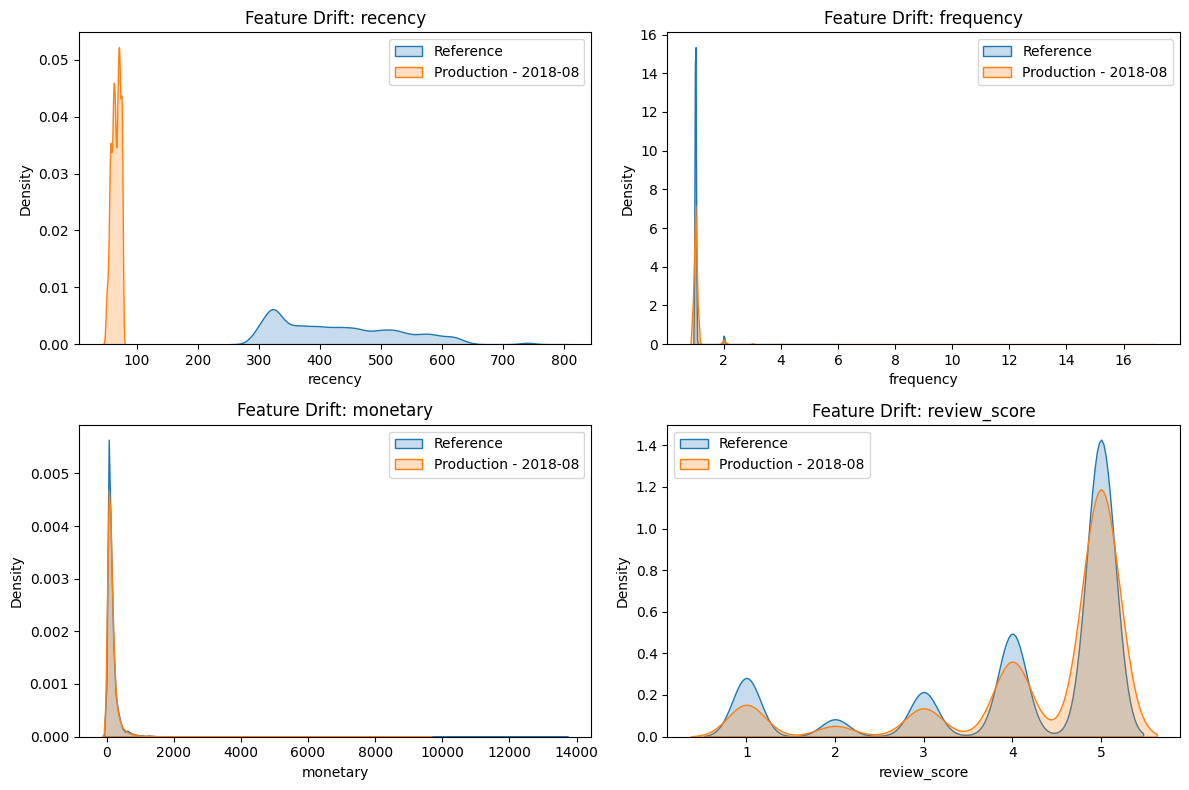

Drift preds for 2018-09 :  {'data': {'is_drift': 1, 'distance': array([0.6389561, 0.5484411, 1.       , 0.6046533], dtype=float32), 'p_val': array([2.7233729e-05, 6.4693316e-04, 0.0000000e+00, 9.8562552e-05],
      dtype=float32), 'threshold': 0.05}, 'meta': {'name': 'TabularDrift', 'online': False, 'data_type': None, 'version': '0.13.0', 'detector_type': 'drift'}}
Drift Detected: 1
Feature-wise P-values:
customer_unique_id: 0.0000
recency: 0.0006
frequency: 0.0000
monetary: 0.0001


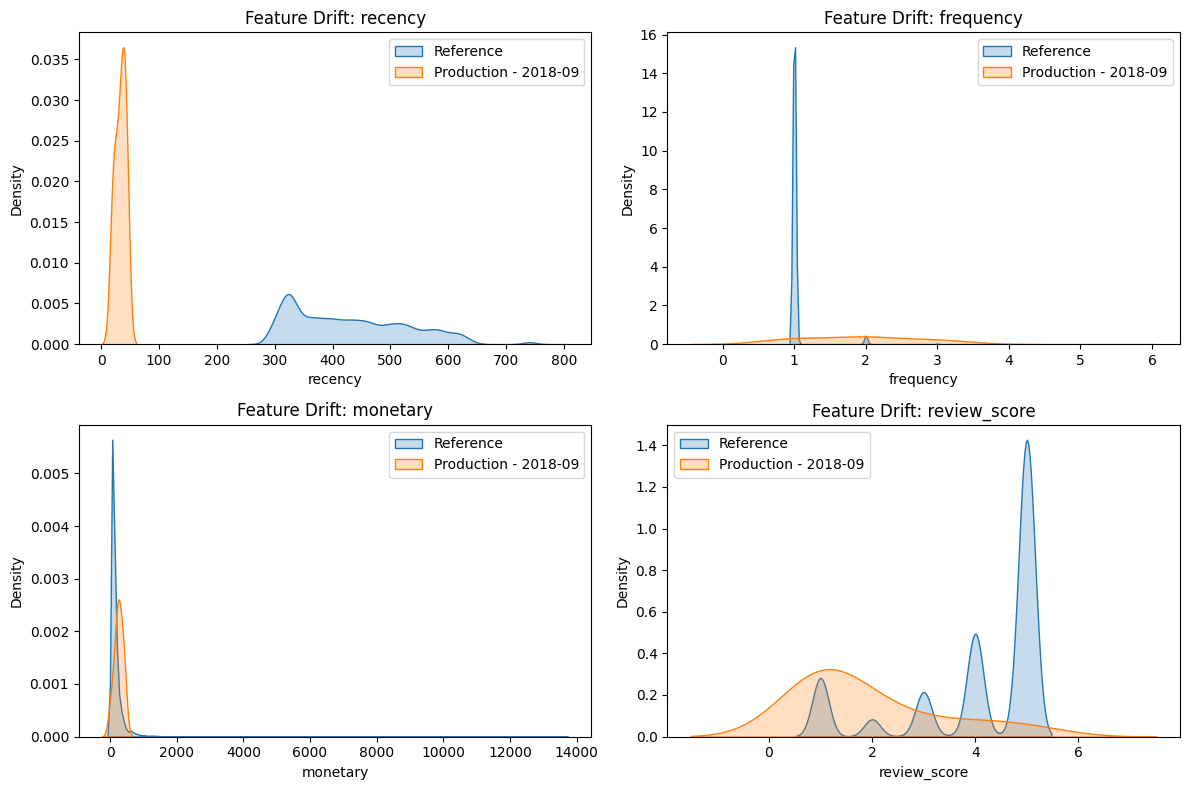

Drift preds for 2018-10 :  {'data': {'is_drift': 1, 'distance': array([0.72228944, 0.45137274, 1.        , 0.6046533 ], dtype=float32), 'p_val': array([0.01201892, 0.28941852, 0.        , 0.06371167], dtype=float32), 'threshold': 0.025}, 'meta': {'name': 'TabularDrift', 'online': False, 'data_type': None, 'version': '0.13.0', 'detector_type': 'drift'}}
Drift Detected: 1
Feature-wise P-values:
customer_unique_id: 0.0120
recency: 0.2894
frequency: 0.0000
monetary: 0.0637


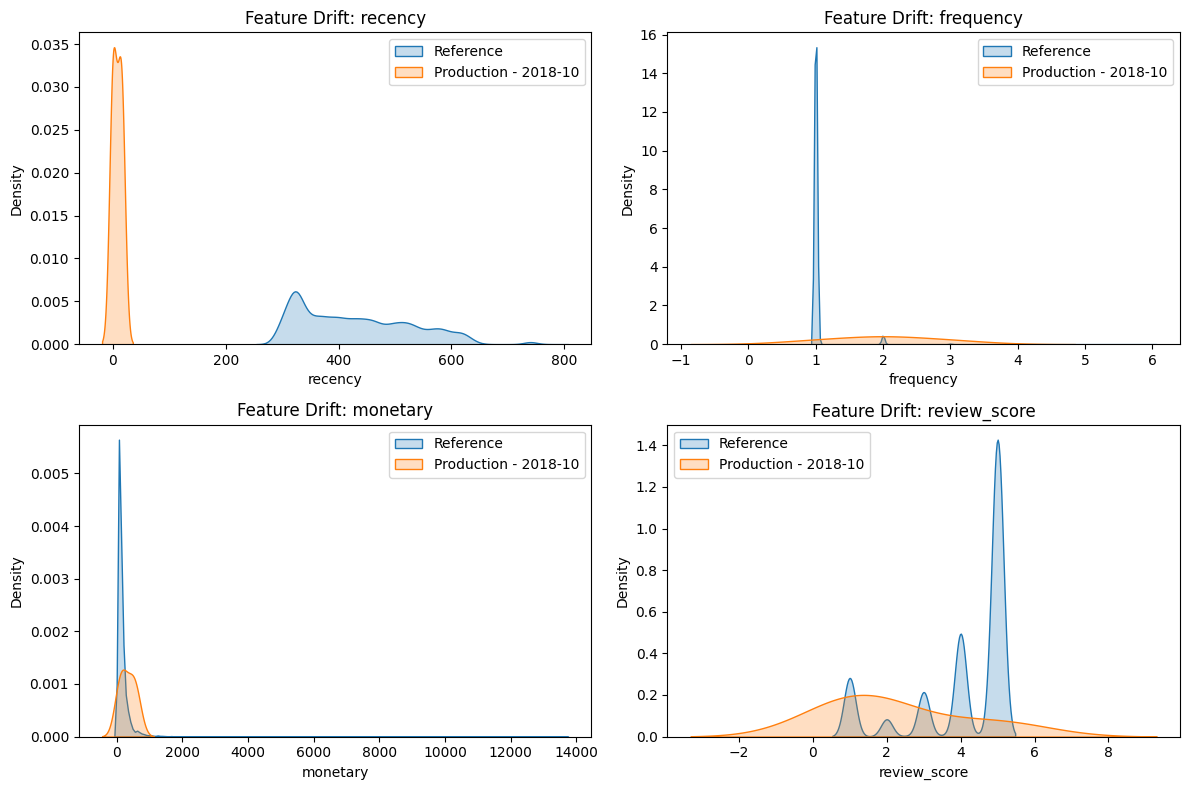

In [11]:
plot_all_data_drift(T_n)

**Cas du mois de Mars**

Les Valeurs de P-values sont nulles étaient prévisibles vues la quantité de données : Un échantillonnage serait pertinent pour ce test statistqiue puisque les données sont amenées à avoir une plus grande taille.

review_score est considéré comme une variable quantitative discrète bormée, quand bien même nous avons calculé les moyennes par client.

Par ailleurs on se rends compte que le Data Drift vient quasiment de la variable ``rececncy``.

### B /  **hausdorff drift**

In [ ]:
def hausdorff_drift_per_cluster(
    X_ref, labels_ref,
    X_cur, labels_cur
):
    """
    Needed only for Cluster shapes drift specially if """
    drifts = {}

    for c in set(labels_ref) - {-1}:
        ref_points = X_ref[labels_ref == c]
        cur_points = X_cur[labels_cur == c]

        # cluster disparu ou vide
        if len(ref_points) == 0 or len(cur_points) == 0:
            drifts[c] = np.nan
            continue

        d1 = directed_hausdorff(ref_points, cur_points)[0]
        d2 = directed_hausdorff(cur_points, ref_points)[0]

        drifts[c] = max(d1, d2)

    return drifts


## **Representation Drifts**

### - **A / Embeddings Drift : Déplacement des centroïdes UMAP**

In [79]:
import numpy as np
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist

In [80]:
# calcul des centroïdes

def compute_centroids(embedding, labels):
    centroids = {}
    for c in set(labels) - {-1}:
        centroids[c] = embedding[labels == c].mean(axis=0)
    return centroids

# matcher les clusters entre T0 et Ti : associer les clusters par proximité

def match_clusters(centroids_ref, centroids_cur):
    C_ref = np.vstack(list(centroids_ref.values())) # obtention des matrices
    C_cur = np.vstack(list(centroids_cur.values()))

    distances = cdist(C_ref, C_cur) # calcul de distance entre tous les points des deux ensembles
    row_ind, col_ind = linear_sum_assignment(distances) # assignation correcte des clusters

    matches = {}
    ref_keys = list(centroids_ref.keys())
    cur_keys = list(centroids_cur.keys())

    for i, j in zip(row_ind, col_ind):
        matches[ref_keys[i]] = cur_keys[j]

    return matches

# calcul du centroid drift

def centroid_drift_matched(embedding_ref, labels_ref, embedding_cur, labels_cur):
    centroids_ref = compute_centroids(embedding_ref, labels_ref)
    centroids_cur = compute_centroids(embedding_cur, labels_cur)

    matches = match_clusters(centroids_ref, centroids_cur)

    drifts = {}
    for c_ref, c_cur in matches.items():
        drifts[c_ref] = np.linalg.norm(
            centroids_ref[c_ref] - centroids_cur[c_cur]
        )

    return drifts


### - **B / Clustering-Based Drift**

A partir des points dans les clusters on peut identifier les clusters qui s'écartent des clusters historiques: cela est aussi utile pour le signalement de dérives de données.



#### - **Taux de Proportion des clusters**

P(cluster = k | t) :  Population de chaque cluster

Détecte :
- croissance
- déclin
- disparition
- émergence

In [91]:
def cluster_proportions(labels):
    unique, counts = np.unique(labels, return_counts=True)
    return dict(zip(unique, counts / len(labels)))

#### - **Taux de bruits DBSCAN (signal fort)**

C'est un signal fort dans le sens où il serait probable que :
- de nouveaux client atypique apparaissent
- de nouvelles données hors distribution apparaissent


In [ ]:
def noise_ratio(labels_cur: np.array):
    noise_ratio = np.mean(labels_cur == -1)
    return noise_ratio

def clustered_ratio(noise_ratio: float):
    return 1 - noise_ratio

- #### **Qualité du clustering DBCV et les autres attributs de clustering**

In [ ]:
def dbcv(X, month: str):
    """
    Get density validity of dbscan clustering model
    X: all data
    month: for data until this month
    Output :
        a tuple of :
            nb_cluster : Number of clusters
            nb_noise : Number of noises
            clustered_ratio : ratio of objects clustered not as a noise
            labels
    """
    from hdbscan.validity import validity_index
    pipeline_instance = RFMSClusteringModel()

    data = []

    X_prod = get_ti_data(X, month)
    pipeline_instance.fit(X_prod)
    x_prod_embedding = pipeline_instance.embedding_

    labels, nb_cluster, noise_ratio, clustered_ratio, dbcv_score = \
        pipeline_instance.dbcv()

    data = {
        'labels' : labels,
        'nb_cluster' : nb_cluster,
        "noise_ratio" : noise_ratio,
        'clustered_ratio': clustered_ratio,
        'dbcv_score' : dbcv_score,
        "ari_score" : None,
        "ami_score" : None,
        "umap_embedding" : x_prod_embedding,
    }

    return data, X_prod, labels


def stability_score(X_prod, labels_prod):
    """
    Parameters :
        X_prod
        labels_prod : labels predicted from dbscan clustering pipeline
    Return ARI score and AMI score

    """
    from sklearn.utils import resample
    from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score

    x_prod_resampled, idx = resample(X_prod, np.arange(len(X_prod)),
                                                    random_state=1, replace=True)

    pipeline_instance  = RFMSClusteringModel()
    pipeline_instance.fit(x_prod_resampled)
    labels_prod_resampled = pipeline_instance.labels_


    # labels_kmeans[idx] = labels des points d'origine correspondant au bootstrap
    ari_stability = adjusted_rand_score(labels_prod[idx], labels_prod_resampled)
    ami_stability = adjusted_mutual_info_score(labels_prod[idx], labels_prod_resampled)

    return ari_stability, ami_stability

In [ ]:
t_k_min = "2017-12"
months = [str(month) for month in sorted(T_n[T_n["month"] >= t_k_min].month.unique())]

data = {}

for month in months:
    dbcv_attribut, X_prod, labels_prod = dbcv(X=T_n, month=month)
    ari_stability, ami_stability = stability_score(X_prod, labels_prod)
    dbcv_attribut["ari_score"] = ari_stability
    dbcv_attribut["ami_score"] = ami_stability

    data[month] = dbcv_attribut


In [ ]:
rows = []
for month, d in data.items():
    rows.append({
        "month": month,
        "dbcv_score": d["dbcv_score"],
        "ari_score": d["ari_score"],
        "ami_score": d["ami_score"],
        "nb_cluster": d["nb_cluster"],
        "noise_ratio": d["noise_ratio"],
        "clustered_ratio": d["clustered_ratio"]
    })

df_metrics = pd.DataFrame(data=data).sort_values(by="month")

# **Monitoring dashboard prototype and Refit data decision**



### **Évolution du DBCV (courbe) et ARI/AMI(stabilité du clustering)**




In [ ]:
import plotly.express as px

fig = px.line(
    df_metrics,
    x="month",
    y="dbcv_score",
    markers=True,
    title="Évolution du DBCV (qualité du clustering)"
)

fig.show()


df_long = df_metrics.melt(
    id_vars="month",
    value_vars=["ari_score", "ami_score"],
    var_name="metric",
    value_name="score"
)

fig = px.bar(
    df_long,
    x="month",
    y="score",
    color="metric",
    barmode="group",
    title="Stabilité du clustering (ARI / AMI)"
)

fig.show()

# plot

## **Visualisation des clusters (UMAP + labels)**

In [ ]:
def umap_df(data, month):
    emb = data[month]["umap_embedding"]
    labels = data[month]["labels"]

    return pd.DataFrame({
        "UMAP-1": emb[:, 0],
        "UMAP-2": emb[:, 1],
        "UMAP-3": emb[:, 2],
        "cluster": labels.astype(str)
    })

month = "2023-06"
df_umap = umap_df(data, month)

fig = px.scatter(
    df_umap,
    x="UMAP-1",
    y="UMAP-2",
    z="UMAP-3",
    color="cluster",
    title=f"UMAP + DBSCAN clusters ({month})",
    opacity=0.7
)

fig.show()


In [ ]:
frames = []

for month in sorted(data.keys()):
    df_umap = umap_df(data, month)
    frames.append(
        dict(
            name=month,
            data=[
                dict(
                    type="scatter3d",
                    x=df_umap["UMAP-1"],
                    y=df_umap["UMAP-2"],
                    z=df_umap["UMAP-3"],
                    mode="markers",
                    marker=dict(
                        size=3,
                        color=df_umap["cluster"].astype("category").cat.codes,
                        opacity=0.7
                    )
                )
            ]
        )
    )

fig = {
    "data": frames[0]["data"],
    "layout": {
        "title": "Évolution temporelle du clustering (UMAP 3D)",
        "scene": {
            "xaxis_title": "UMAP-1",
            "yaxis_title": "UMAP-2",
            "zaxis_title": "UMAP-3"
        },
        "updatemenus": [{
            "type": "buttons",
            "buttons": [{
                "label": "Play",
                "method": "animate",
                "args": [None, {"frame": {"duration": 800, "redraw": True}}]
            }]
        }],
        "sliders": [{
            "steps": [
                {
                    "method": "animate",
                    "args": [[f["name"]], {"mode": "immediate"}],
                    "label": f["name"]
                }
                for f in frames
            ]
        }]
    },
    "frames": frames
}

import plotly.io as pio
pio.show(fig)
